In [16]:
import pandas as pd
import numpy as np
import time
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from prophet.serialize import model_from_json # Import Prophet loader
import json # Import json

# Import feature generation functions
try:
    import sys
    sys.path.append('../api')
    from features import generate_full_features, generate_simple_features
except ImportError:
    print("ERROR: Could not import feature generation functions.")

    def generate_full_features(*args, **kwargs): raise NotImplementedError("generate_full_features not imported")
    def generate_simple_features(*args, **kwargs): raise NotImplementedError("generate_simple_features not imported")

# Setup
sns.set_style("whitegrid")
BASE_DIR = Path.cwd().parent

# --- Load Models (UPDATED) ---
print("Loading models...")
models_to_load = {
    "ARIMA": BASE_DIR / "models/arima_model.pkl", # Added
    "SARIMA": BASE_DIR / "models/sarima_baseline_model.pkl",
    "Prophet": BASE_DIR / "models/prophet_baseline_model.json", # Added
    "RandomForest": BASE_DIR / "models/random_forest_model.pkl",
    "XGBoost": BASE_DIR / "models/xgboost_model.pkl",
    "LightGBM": BASE_DIR / "models/light_gbm_model.pkl",
    "XGBoost_Tuned": BASE_DIR / "models/xgboost_tuned_model.pkl",
    "Voting": BASE_DIR / "models/voting_model.pkl", # Added
    "Stacking": BASE_DIR / "models/stacking_model.pkl", # Added
    "LSTM": BASE_DIR / "models/lstm_model.keras",
    "GRU": BASE_DIR / "models/gru_model.keras", # Added
    "Transformer": BASE_DIR / "models/transformer_model.keras", # Added
}
loaded_models = {}
for name, path in models_to_load.items():
    try:
        if not path.exists():
            print(f"   - WARNING: File not found for '{name}' at {path}. Skipping.")
            continue
        if path.suffix == '.keras':
            loaded_models[name] = tf.keras.models.load_model(path)
        elif path.suffix == '.json': # Specifically for Prophet
             with open(path, 'r') as f:
                  loaded_models[name] = model_from_json(json.load(f))
        else: # .pkl files
            loaded_models[name] = joblib.load(path)
        print(f" - Model '{name}' loaded.")
    except Exception as e:
        print(f"   - ERROR loading '{name}': {e}")

# Load scaler (needed for DL models)
try:
    scaler_path = BASE_DIR / 'models/standard_scaler.pkl'
    if scaler_path.exists():
        scaler = joblib.load(scaler_path)
        print(" - Scaler loaded.")
    else:
        scaler = None
        print(" - WARNING: Scaler file not found.")
except Exception as e:
    print(f"   - ERROR loading scaler: {e}")
    scaler = None

print(f"Model loading complete. {len(loaded_models)} models loaded.")
# --- End Load Models ---

# Load data
try:
    hourly_data_path = BASE_DIR / "data/dataset_for_modeling.csv"
    if not hourly_data_path.exists(): raise FileNotFoundError("Hourly data file missing.")
    df_hourly = pd.read_csv(hourly_data_path, index_col='DateTime', parse_dates=True)
    df_daily = df_hourly['Global_active_power'].resample('D').sum().to_frame()
    print("Historical data loaded.")
except Exception as e:
    print(f"ERROR loading data: {e}")
    df_hourly = None
    df_daily = None

Importing plotly failed. Interactive plots will not work.


Loading models...
 - Model 'ARIMA' loaded.
 - Model 'SARIMA' loaded.
 - Model 'Prophet' loaded.
 - Model 'RandomForest' loaded.
 - Model 'XGBoost' loaded.
 - Model 'LightGBM' loaded.
 - Model 'XGBoost_Tuned' loaded.
 - Model 'Voting' loaded.
 - Model 'Stacking' loaded.
 - Model 'LSTM' loaded.
 - Model 'GRU' loaded.
 - Model 'Transformer' loaded.
 - Scaler loaded.
Model loading complete. 12 models loaded.
Historical data loaded.


In [17]:
input_data = {}
n_periods = 1 # For single prediction latency test

if df_daily is not None and df_hourly is not None:
    last_daily_date = df_daily.index.max()
    last_hourly_date = df_hourly.index.max()

    # --- ARIMA & SARIMA ---
    input_data['ARIMA'] = {'n_periods': n_periods}
    input_data['SARIMA'] = {'n_periods': n_periods}

    # --- Prophet ---
    future_date_prophet = pd.date_range(start=last_daily_date + pd.Timedelta(days=1), periods=n_periods, freq='D')
    input_data['Prophet'] = pd.DataFrame({'ds': future_date_prophet})

    # --- XGBoost_Tuned, Voting, Stacking (daily, simple features) ---
    future_date_simple = pd.date_range(start=last_daily_date + pd.Timedelta(days=1), periods=n_periods, freq='D')
    simple_features_input = generate_simple_features(future_date_simple)
    input_data['XGBoost_Tuned'] = simple_features_input
    input_data['Voting'] = simple_features_input
    input_data['Stacking'] = simple_features_input
    print("Prepared input for XGBoost_Tuned, Voting, Stacking.")

    # --- RandomForest, XGBoost, LightGBM (hourly, full features) ---
    try:
        history_slice_full = df_hourly.tail(168)
        future_date_hourly = pd.date_range(start=last_hourly_date + pd.Timedelta(hours=1), periods=n_periods, freq='h')
        full_features_input = generate_full_features(history_slice_full, future_date_hourly)
        input_data['RandomForest'] = full_features_input
        input_data['XGBoost'] = full_features_input
        input_data['LightGBM'] = full_features_input
        print("Prepared input for RF, XGB, LGBM.")
    except Exception as e:
         print(f"ERROR preparing full features: {e}. RF, XGB, LGBM tests might fail.")

    # --- LSTM, GRU, Transformer (hourly, base scaled, sequence) ---
    if scaler:
        try:
            sequence_len = 24 # Assuming same sequence length for all DL models
            dl_input_raw = df_hourly.iloc[-sequence_len:]
            scaler_features = scaler.get_feature_names_out()
            if not set(scaler_features).issubset(dl_input_raw.columns):
                 raise ValueError("Missing columns needed by scaler in historical data.")
            dl_input_subset = dl_input_raw[scaler_features]
            dl_input_scaled = scaler.transform(dl_input_subset)

            target_index = list(scaler_features).index('Global_active_power')
            X_input_dl = np.delete(dl_input_scaled, target_index, axis=1)
            dl_sequence_input = np.expand_dims(X_input_dl, axis=0) # Shape: (1, seq_len, num_features-1)

            input_data['LSTM'] = dl_sequence_input
            input_data['GRU'] = dl_sequence_input
            input_data['Transformer'] = dl_sequence_input
            print("Prepared input for LSTM, GRU, Transformer.")
        except Exception as e:
            print(f"ERROR preparing DL input data: {e}. LSTM, GRU, Transformer tests might fail.")
    else:
        print("Scaler not loaded, skipping DL input data preparation.")

else:
    print("Data not loaded, cannot prepare input data.")

# Verify shapes/params
print("\n--- Input Data Summary ---")
for name, data in input_data.items():
     if isinstance(data, pd.DataFrame): print(f"Shape for {name}: {data.shape}")
     elif isinstance(data, np.ndarray): print(f"Shape for {name}: {data.shape}")
     elif isinstance(data, dict): print(f"Params for {name}: {data}")

Prepared input for XGBoost_Tuned, Voting, Stacking.
Prepared input for RF, XGB, LGBM.
Prepared input for LSTM, GRU, Transformer.

--- Input Data Summary ---
Params for ARIMA: {'n_periods': 1}
Params for SARIMA: {'n_periods': 1}
Shape for Prophet: (1, 1)
Shape for XGBoost_Tuned: (1, 3)
Shape for Voting: (1, 3)
Shape for Stacking: (1, 3)
Shape for RandomForest: (1, 36)
Shape for XGBoost: (1, 36)
Shape for LightGBM: (1, 36)
Shape for LSTM: (1, 24, 7)
Shape for GRU: (1, 24, 7)
Shape for Transformer: (1, 24, 7)


In [21]:
# --- ОНОВЛЕНА КОМІРКА 4: Оцінка споживання пам'яті (включаючи ARIMA/SARIMA) ---
from memory_profiler import memory_usage
import time
import re

# Переконайтесь, що розширення завантажено
try:
    %load_ext memory_profiler
except ModuleNotFoundError:
    print("ПОМИЛКА: Бібліотеку 'memory-profiler' не знайдено. Встановіть її: pip install memory-profiler")

print("\nОцінка споживання пам'яті (Memory Cost)...")

# Словник для зберігання результатів increment
memory_increments = {}

for name, model in loaded_models.items():
     if name not in input_data:
         print(f"\n--- {name} ---")
         print(f"   - Пропуск {name}: немає підготовлених вхідних даних.")
         memory_increments[name] = None
         continue

     data_for_eval = input_data[name]
     print(f"\n--- {name} ---")

     # Визначаємо функцію для профілювання
     def predict_func():
         if name in ['ARIMA', 'SARIMA']:
             # Використовуємо параметри (n_periods) з data_for_eval
             model.predict(n_periods=data_for_eval['n_periods'])
         elif name == 'Prophet':
             model.predict(data_for_eval)
         elif name in ['LSTM', 'GRU', 'Transformer']:
             _ = model(data_for_eval, training=False)
         elif isinstance(data_for_eval, pd.DataFrame):
             # Готуємо дані для ML моделей
             input_df_mem = data_for_eval
             if hasattr(model, 'feature_names_in_'):
                  input_df_mem = data_for_eval[model.feature_names_in_]
             model.predict(input_df_mem)
         else:
             model.predict(data_for_eval)

     try:
         # Вимірюємо пам'ять
         mem_before = memory_usage(-1, interval=0.01, timeout=1)[0]
         time.sleep(0.1)
         # Виконуємо функцію, вимірюючи пікове споживання
         mem_during = memory_usage((predict_func,), interval=0.05, timeout=120, max_usage=True, retval=False, include_children=True)
         time.sleep(0.1)

         # mem_during тепер має містити одне число - пікове значення
         if isinstance(mem_during, list) and len(mem_during) > 0:
             peak_during = mem_during[0] # max_usage=True повертає список з одним піковим значенням
         elif isinstance(mem_during, float):
             peak_during = mem_during # Або просто число
         else:
             raise ValueError(f"Неочікуваний результат від memory_usage: {mem_during}")

         increment = peak_during - mem_before
         memory_increments[name] = increment
         print(f"   - Memory Before: {mem_before:.2f} MiB")
         print(f"   - Peak Memory During: {peak_during:.2f} MiB")
         print(f"   - Increment (Peak - Before): {increment:.2f} MiB")

     except Exception as e:
         print(f"   - ПОМИЛКА профілювання для {name}: {e}")
         memory_increments[name] = None

# Виводимо зведену таблицю
print("\n--- Memory Consumption Summary (Increment: Peak - Before) ---")
for name, increment in memory_increments.items():
     print(f" - {name}: {increment:.2f} MiB" if increment is not None else f" - {name}: N/A")

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler

Оцінка споживання пам'яті (Memory Cost)...

--- ARIMA ---


/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast

   - Memory Before: 279.02 MiB
   - Peak Memory During: 316.80 MiB
   - Increment (Peak - Before): 37.78 MiB

--- SARIMA ---


/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kolya/PycharmProjects/energy_forecast

   - Memory Before: 308.91 MiB
   - Peak Memory During: 321.44 MiB
   - Increment (Peak - Before): 12.53 MiB

--- Prophet ---
   - Memory Before: 313.53 MiB
   - Peak Memory During: 384.11 MiB
   - Increment (Peak - Before): 70.58 MiB

--- RandomForest ---
   - Memory Before: 325.72 MiB
   - Peak Memory During: 391.83 MiB
   - Increment (Peak - Before): 66.11 MiB

--- XGBoost ---
   - Memory Before: 334.75 MiB
   - Peak Memory During: 346.42 MiB
   - Increment (Peak - Before): 11.67 MiB

--- LightGBM ---
   - Memory Before: 338.38 MiB
   - Peak Memory During: 349.89 MiB
   - Increment (Peak - Before): 11.52 MiB

--- XGBoost_Tuned ---
   - Memory Before: 341.84 MiB
   - Peak Memory During: 351.30 MiB
   - Increment (Peak - Before): 9.45 MiB

--- Voting ---
   - Memory Before: 343.25 MiB
   - Peak Memory During: 356.72 MiB
   - Increment (Peak - Before): 13.47 MiB

--- Stacking ---
   - Memory Before: 348.67 MiB
   - Peak Memory During: 361.97 MiB
   - Increment (Peak - Before): 13.30 Mi

In [19]:
# --- UPDATED CELL 4: Memory Cost Estimation (v4 - using API) ---
from memory_profiler import memory_usage
import time
import re
import pandas as pd
from IPython.display import display

# Ensure the library is installed
try:
    import memory_profiler
except ModuleNotFoundError:
    print("ERROR: 'memory-profiler' library not found. Install it: pip install memory-profiler")

print("\nEstimating Memory Consumption (Memory Cost)...")
memory_results = []

for name, model in loaded_models.items():
    # Skip models difficult to profile accurately this way or without input
    if name in ['SARIMA', 'ARIMA'] or name not in input_data:
        print(f"\n--- {name} ---")
        print(f"   - Skipping memory profiling for {name}.")
        memory_results.append({
            'Model': name,
            'Memory Before (MiB)': None,
            'Peak Memory During (MiB)': None,
            'Memory After (MiB)': None,
            'Increment Peak-Before (MiB)': None,
            'Increment After-Before (MiB)': None,
            'Status': 'Skipped'
        })
        continue

    data_for_eval = input_data[name]
    print(f"\n--- {name} ---")

    # Define the prediction function to profile
    def predict_func():
        if name == 'Prophet':
            model.predict(data_for_eval)
        elif name in ['LSTM', 'GRU', 'Transformer']:
            _ = model(data_for_eval, training=False)
        elif isinstance(data_for_eval, pd.DataFrame):
            input_df_mem = data_for_eval
            if hasattr(model, 'feature_names_in_'):
                input_df_mem = data_for_eval[model.feature_names_in_]
            model.predict(input_df_mem)
        else:  # Should not happen based on input prep
            model.predict(data_for_eval)

    try:
        # Measure memory
        mem_before = memory_usage(-1, interval=0.01, timeout=1)[0]
        time.sleep(0.1)
        # Execute function while measuring; max_usage=False returns list of measurements
        mem_during = memory_usage((predict_func,), interval=0.05, timeout=120, retval=False, include_children=True)
        time.sleep(0.1)
        mem_after = memory_usage(-1, interval=0.01, timeout=1)[0]

        if mem_during:  # Check if measurement list is not empty
            peak_during = max(mem_during)
            increment_peak = peak_during - mem_before
            increment_after = mem_after - mem_before

            print(f"   - Memory Before: {mem_before:.2f} MiB")
            print(f"   - Peak Memory During: {peak_during:.2f} MiB")
            print(f"   - Memory After: {mem_after:.2f} MiB")
            print(f"   - Increment (Peak - Before): {increment_peak:.2f} MiB")
            print(f"   - Increment (After - Before): {increment_after:.2f} MiB")

            memory_results.append({
                'Model': name,
                'Memory Before (MiB)': round(mem_before, 2),
                'Peak Memory During (MiB)': round(peak_during, 2),
                'Memory After (MiB)': round(mem_after, 2),
                'Increment Peak-Before (MiB)': round(increment_peak, 2),
                'Increment After-Before (MiB)': round(increment_after, 2),
                'Status': 'Success'
            })
        else:
            print("   - Failed to get memory measurements during execution.")
            memory_results.append({
                'Model': name,
                'Memory Before (MiB)': None,
                'Peak Memory During (MiB)': None,
                'Memory After (MiB)': None,
                'Increment Peak-Before (MiB)': None,
                'Increment After-Before (MiB)': None,
                'Status': 'Failed - No measurements'
            })

    except Exception as e:
        print(f"   - ERROR during profiling for {name}: {e}")
        memory_results.append({
            'Model': name,
            'Memory Before (MiB)': None,
            'Peak Memory During (MiB)': None,
            'Memory After (MiB)': None,
            'Increment Peak-Before (MiB)': None,
            'Increment After-Before (MiB)': None,
            'Status': f'Error: {str(e)}'
        })

# Create DataFrame and display as table
print("\n" + "="*100)
print("MEMORY CONSUMPTION SUMMARY TABLE")
print("="*100 + "\n")

memory_df = pd.DataFrame(memory_results)
display(memory_df)

# Optional: Save to CSV
memory_df.to_csv('memory_consumption_results.csv', index=False)
print("\n✓ Results saved to 'memory_consumption_results.csv'")

# Print simplified summary
print("\n" + "="*100)
print("SIMPLIFIED SUMMARY (Memory Increment: Peak - Before)")
print("="*100)
summary_df = memory_df[['Model', 'Increment Peak-Before (MiB)', 'Status']].copy()
display(summary_df)


Estimating Memory Consumption (Memory Cost)...

--- ARIMA ---
   - Skipping memory profiling for ARIMA.

--- SARIMA ---
   - Skipping memory profiling for SARIMA.

--- Prophet ---
   - Memory Before: 593.22 MiB
   - Peak Memory During: 651.28 MiB
   - Memory After: 593.70 MiB
   - Increment (Peak - Before): 58.06 MiB
   - Increment (After - Before): 0.48 MiB

--- RandomForest ---
   - Memory Before: 593.70 MiB
   - Peak Memory During: 650.97 MiB
   - Memory After: 593.73 MiB
   - Increment (Peak - Before): 57.27 MiB
   - Increment (After - Before): 0.03 MiB

--- XGBoost ---
   - Memory Before: 593.73 MiB
   - Peak Memory During: 602.14 MiB
   - Memory After: 594.09 MiB
   - Increment (Peak - Before): 8.41 MiB
   - Increment (After - Before): 0.36 MiB

--- LightGBM ---
   - Memory Before: 594.09 MiB
   - Peak Memory During: 602.42 MiB
   - Memory After: 594.38 MiB
   - Increment (Peak - Before): 8.33 MiB
   - Increment (After - Before): 0.28 MiB

--- XGBoost_Tuned ---
   - Memory Befor

Starting scalability test...
Batch size: 1, Time: 0.0010 seconds
Batch size: 10, Time: 0.0006 seconds
Batch size: 50, Time: 0.0005 seconds
Batch size: 100, Time: 0.0006 seconds
Batch size: 200, Time: 0.0005 seconds
Batch size: 330, Time: 0.0005 seconds


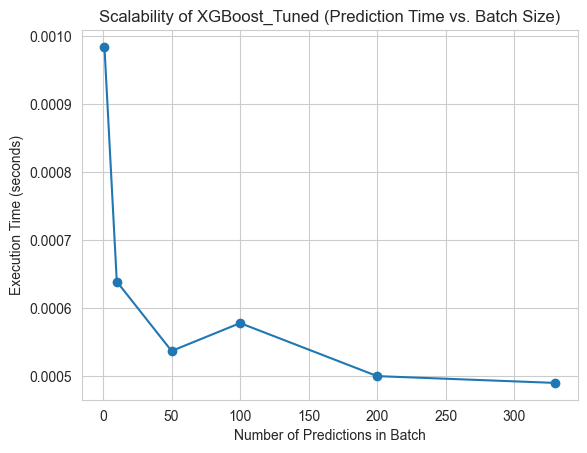

In [20]:
batch_sizes = [1, 10, 50, 100, 200, 330]
scalability_results = []

# --- Prepare features ---
xgb_feature_names = ['day_of_week', 'month', 'day_of_year']
X_daily_features_full = df_daily.loc['2010-01-01':].copy() # Assuming df_daily is defined earlier
X_daily_features_full['day_of_week'] = X_daily_features_full.index.dayofweek
X_daily_features_full['month'] = X_daily_features_full.index.month
X_daily_features_full['day_of_year'] = X_daily_features_full.index.dayofyear
X_daily_test_final = X_daily_features_full[xgb_feature_names]
# -------------------------------

print("Starting scalability test...")
# Get the correct model from the dictionary loaded in Cell 1
model_to_test = loaded_models.get('XGBoost_Tuned') # Use .get for safety

if model_to_test:
    for size in batch_sizes:
        batch_input = X_daily_test_final.iloc[:size]

        start_time = time.time()
        # --- Use the retrieved model ---
        model_to_test.predict(batch_input)
        # --- End fix ---
        end_time = time.time()

        scalability_results.append(end_time - start_time)
        print(f"Batch size: {size}, Time: {end_time - start_time:.4f} seconds")

    # Visualization
    plt.plot(batch_sizes, scalability_results, marker='o')
    plt.title('Scalability of XGBoost_Tuned (Prediction Time vs. Batch Size)') # Updated title
    plt.xlabel('Number of Predictions in Batch')
    plt.ylabel('Execution Time (seconds)')
    plt.show()
else:
    print("ERROR: 'XGBoost_Tuned' model not found in loaded_models. Cannot run scalability test.")